In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# For text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

# For visualization
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# For machine learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load and combine all training CSV files
def load_training_data(data_dir='data/Train'):
    """Load and combine all training CSV files from different LLMs"""
    all_data = []
    
    # List of LLM platforms
    llm_platforms = ['claude', 'deepseek', 'gemini', 'gpt', 'grok', 'perplexity']
    
    for platform in llm_platforms:
        file_path = os.path.join(data_dir, f'{platform}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Platform'] = platform  # Add platform identifier
            all_data.append(df)
        else:
            print(f"Warning: File {file_path} not found")
    
    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Load training data
train_df = load_training_data()

# Display basic information about the dataset
print("Dataset Shape:", train_df.shape)
print("\nDataset Info:")
print(train_df.info())
print("\nFirst few rows:")
print(train_df.head())

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WINDOWS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\WINDOWS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\WINDOWS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset Shape: (130885, 5)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130885 entries, 0 to 130884
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Comment     130880 non-null  object
 1   At          130885 non-null  object
 2   AppVersion  117792 non-null  object
 3   Sentiment   130885 non-null  int64 
 4   Platform    130885 non-null  object
dtypes: int64(1), object(4)
memory usage: 5.0+ MB
None

First few rows:
                                             Comment                   At  \
0         Ridiculous how we are limited when paying!  2025-06-10 21:24:17   
1  love this app but would like a download icon t...  2025-04-05 21:24:04   
2  perfect AI i can't compare with even Chatgpt t...  2025-05-30 08:17:46   
3  can't access projects directly yet, but still ...  2024-08-17 17:31:07   
4                                      very good app  2025-06-16 18:33:42   

    AppVersion  Sentiment 

In [2]:
# Check for missing values
print("\nMissing Values:")
print(train_df.isnull().sum())

# Check for duplicates
print("\nDuplicate Rows:", train_df.duplicated().sum())
train_df.dropna(inplace=True)
train_df.drop_duplicates(inplace=True)
print("After cleaning, Dataset Shape:", train_df.shape)

# Display unique values in Sentiment column
print("\nSentiment Distribution:")
print(train_df['Sentiment'].value_counts())


Missing Values:
Comment           5
At                0
AppVersion    13093
Sentiment         0
Platform          0
dtype: int64

Duplicate Rows: 0
After cleaning, Dataset Shape: (117792, 5)

Sentiment Distribution:
Sentiment
2    98702
0    14079
1     5011
Name: count, dtype: int64


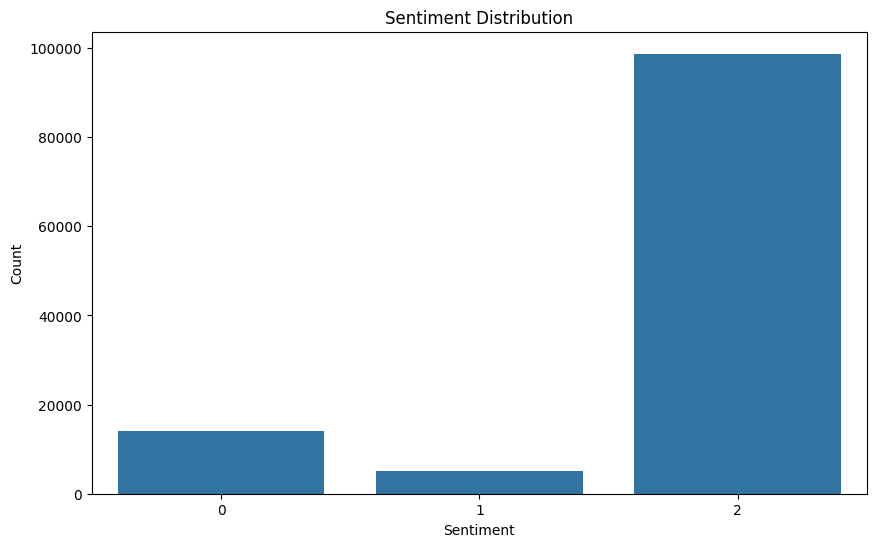

In [4]:
# Perform comprehensive EDA

# 1. Sentiment distribution visualization
plt.figure(figsize=(10, 6))
sns.countplot(data=train_df, x='Sentiment')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

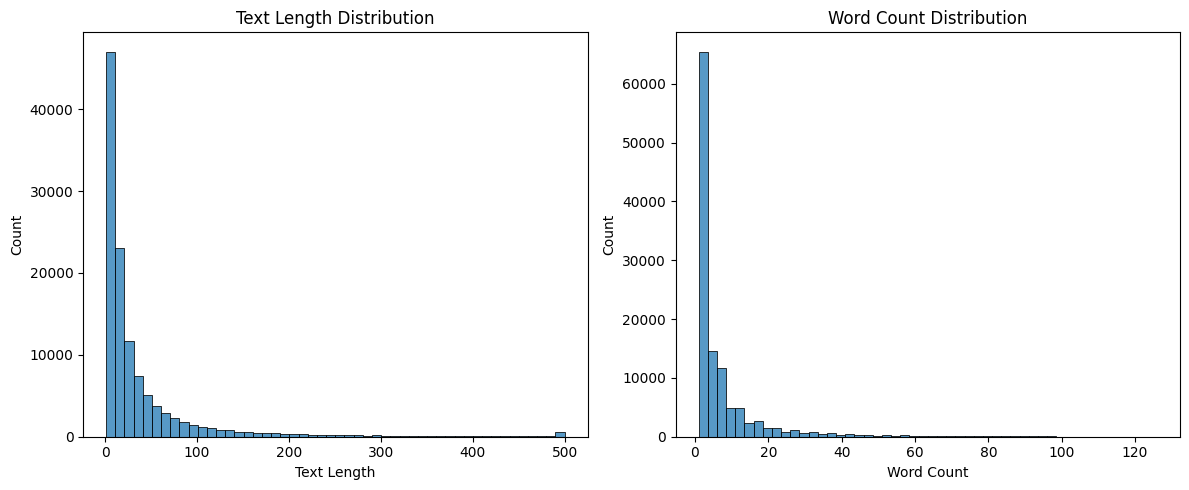

In [5]:
# 2. Text length distributions
train_df['text_length'] = train_df['Comment'].astype(str).apply(len)
train_df['word_count'] = train_df['Comment'].astype(str).apply(lambda x: len(x.split()))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(train_df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')

plt.subplot(1, 2, 2)
sns.histplot(train_df['word_count'], bins=50)
plt.title('Word Count Distribution')
plt.xlabel('Word Count')

plt.tight_layout()
plt.show()

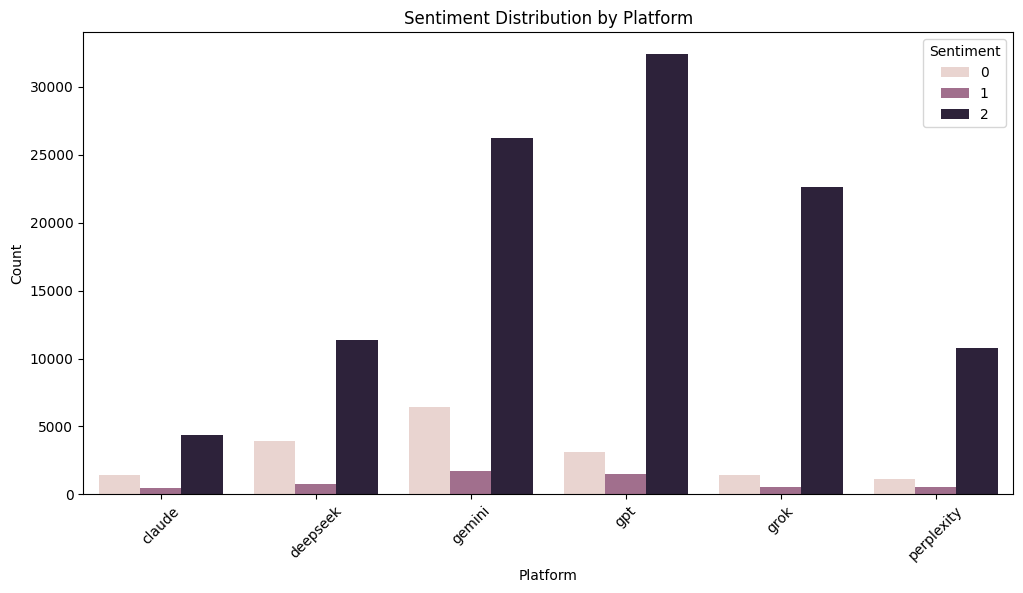

<Figure size 1200x600 with 0 Axes>

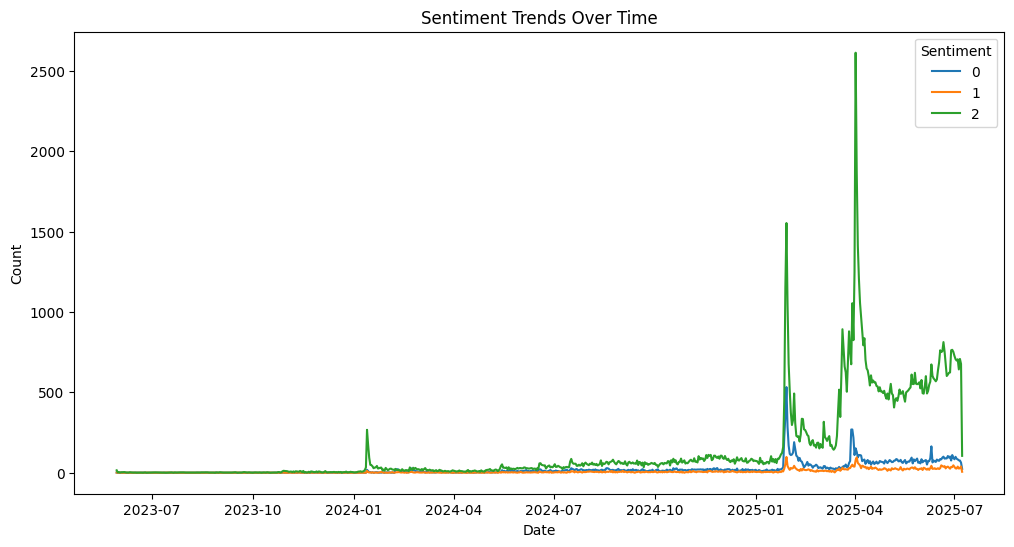


App Version Distribution:
AppVersion
1.0.686588308    10809
1.0.8             6296
1.0.751104895     5854
1.2025.154        4576
1.2025.084        4146
1.2025.105        3151
0.3.2             3120
1.2025.091        3005
1.0.626720042     2936
1.0.668480831     2793
Name: count, dtype: int64


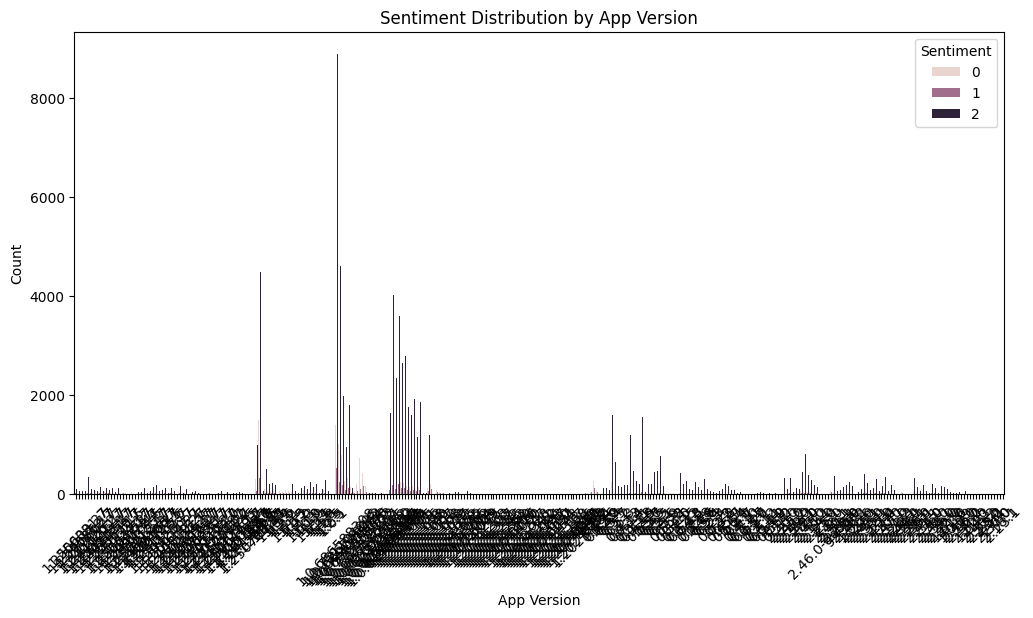

In [5]:
# 3. Sentiment distribution by platform
plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='Platform', hue='Sentiment')
plt.title('Sentiment Distribution by Platform')
plt.xlabel('Platform')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

# 4. Temporal patterns analysis
# Convert 'At' column to datetime
train_df['At'] = pd.to_datetime(train_df['At'])

# Extract date components
train_df['Year'] = train_df['At'].dt.year
train_df['Month'] = train_df['At'].dt.month
train_df['Day'] = train_df['At'].dt.day

# Sentiment over time
plt.figure(figsize=(12, 6))
sentiment_over_time = train_df.groupby([train_df['At'].dt.date, 'Sentiment']).size().unstack(fill_value=0)
sentiment_over_time.plot(kind='line', figsize=(12, 6))
plt.title('Sentiment Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()

# 5. App version impact analysis
print("\nApp Version Distribution:")
print(train_df['AppVersion'].value_counts().head(10))

plt.figure(figsize=(12, 6))
sns.countplot(data=train_df, x='AppVersion', hue='Sentiment')
plt.title('Sentiment Distribution by App Version')
plt.xlabel('App Version')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.show()

In [6]:
# Text preprocessing functions
def clean_text(text):
    """Clean text by removing URLs, mentions, special characters, etc."""
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def advanced_clean_text(text):
    """More aggressive text cleaning"""
    if pd.isna(text):
        return ""
    
    # Apply basic cleaning
    text = clean_text(text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove digits
    text = re.sub(r'\d+', '', text)
    
    return text

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, use_lemmatization=True, remove_stopwords=True):
    """Preprocess text with tokenization, lemmatization, and stopword removal"""
    if pd.isna(text):
        return ""
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Lemmatize if specified
    if use_lemmatization:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join tokens back into text
    return ' '.join(tokens)

# Apply preprocessing to training data
print("Applying text preprocessing...")
train_df['cleaned_text'] = train_df['Comment'].apply(clean_text)
train_df['advanced_cleaned_text'] = train_df['Comment'].apply(advanced_clean_text)
train_df['processed_text'] = train_df['advanced_cleaned_text'].apply(

    lambda x: preprocess_text(x, use_lemmatization=True, remove_stopwords=True)
)

# Display preprocessing results
print("Original text:", train_df['Comment'].iloc[0])
print("Cleaned text:", train_df['cleaned_text'].iloc[0])
print("Advanced cleaned text:", train_df['advanced_cleaned_text'].iloc[0])
print("Processed text:", train_df['processed_text'].iloc[0])

Applying text preprocessing...
Original text: Ridiculous how we are limited when paying!
Cleaned text: ridiculous how we are limited when paying!
Advanced cleaned text: ridiculous how we are limited when paying
Processed text: ridiculous limited paying


In [7]:
# Handle class imbalance
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Check class distribution
print("Class distribution before handling imbalance:")
print(train_df['Sentiment'].value_counts())

# Compute class weights for use in models
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Sentiment']),
    y=train_df['Sentiment']
)
class_weight_dict = dict(zip(np.unique(train_df['Sentiment']), class_weights))
print("\nClass weights:", class_weight_dict)

Class distribution before handling imbalance:
Sentiment
2    98702
0    14079
1     5011
Name: count, dtype: int64

Class weights: {np.int64(0): np.float64(2.788834434263797), np.int64(1): np.float64(7.835561764118938), np.int64(2): np.float64(0.3978034892909971)}


In [8]:
# TF-IDF Vectorization
print("Creating TF-IDF features...")

# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Limit vocabulary size
    ngram_range=(1, 3),  # Use unigrams, bigrams, and trigrams
    min_df=2,            # Ignore terms that appear in less than 2 documents
    max_df=0.95,         # Ignore terms that appear in more than 95% of documents
    stop_words='english'
)

# Fit and transform the processed text
tfidf_features = tfidf_vectorizer.fit_transform(train_df['processed_text'])

print("TF-IDF features shape:", tfidf_features.shape)

# Extract linguistic features
def extract_linguistic_features(df):
    """Extract linguistic features from text"""
    features = pd.DataFrame()
    
    # Text statistics
    features['text_length'] = df['Comment'].astype(str).apply(len)
    features['word_count'] = df['Comment'].astype(str).apply(lambda x: len(x.split()))
    features['avg_word_length'] = features['text_length'] / (features['word_count'] + 1)  # +1 to avoid division by zero
    
    # Punctuation density
    features['exclamation_count'] = df['Comment'].astype(str).apply(lambda x: x.count('!'))
    features['question_count'] = df['Comment'].astype(str).apply(lambda x: x.count('?'))
    features['punctuation_density'] = (features['exclamation_count'] + features['question_count']) / (features['text_length'] + 1)
    
    # Capitalization ratio
    features['capital_ratio'] = df['Comment'].astype(str).apply(
        lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1)
    )
    
    # Sentiment lexicon scores (simplified approach)
    # In a real implementation, you would use VADER or TextBlob here
    positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic']
    negative_words = ['bad', 'terrible', 'awful', 'horrible', 'worst', 'disappointing']
    
    features['positive_word_count'] = df['processed_text'].apply(
        lambda x: sum(1 for word in x.split() if word in positive_words)
    )
    features['negative_word_count'] = df['processed_text'].apply(
        lambda x: sum(1 for word in x.split() if word in negative_words)
    )
    
    return features

# Extract linguistic features
linguistic_features = extract_linguistic_features(train_df)
print("Linguistic features shape:", linguistic_features.shape)
print(linguistic_features.head())

Creating TF-IDF features...
TF-IDF features shape: (117792, 10000)
Linguistic features shape: (117792, 9)
   text_length  word_count  avg_word_length  exclamation_count  \
0           42           7         5.250000                  1   
1           77          15         4.812500                  0   
2           71          12         5.461538                  0   
3           61           9         6.100000                  1   
4           13           3         3.250000                  0   

   question_count  punctuation_density  capital_ratio  positive_word_count  \
0               0             0.023256       0.023256                    0   
1               0             0.000000       0.000000                    0   
2               0             0.000000       0.041667                    0   
3               0             0.016129       0.000000                    0   
4               0             0.000000       0.000000                    1   

   negative_word_count  
0  

In [9]:
# Prepare data for modeling
from scipy.sparse import hstack

# Combine TF-IDF features with linguistic features
combined_features = hstack([tfidf_features, linguistic_features.values])

# Encode target variable if needed
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train_df['Sentiment'])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    combined_features, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (94233, 10009)
Validation set shape: (23559, 10009)


In [10]:
# Implement multiple model architectures

# 1. Logistic Regression
print("Training Logistic Regression...")
lr_model = LogisticRegression(
    class_weight=class_weight_dict,
    random_state=42,
    max_iter=1000
)
lr_model.fit(X_train, y_train)

# Evaluate Logistic Regression
lr_pred = lr_model.predict(X_val)
lr_accuracy = accuracy_score(y_val, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, lr_pred))

Training Logistic Regression...
Logistic Regression Accuracy: 0.7010

Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.71      0.50      2816
           1       0.09      0.32      0.15      1002
           2       0.95      0.72      0.82     19741

    accuracy                           0.70     23559
   macro avg       0.48      0.58      0.49     23559
weighted avg       0.84      0.70      0.75     23559



In [11]:
# 2. Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Evaluate Random Forest
rf_pred = rf_model.predict(X_val)
rf_accuracy = accuracy_score(y_val, rf_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, rf_pred))

Training Random Forest...
Random Forest Accuracy: 0.7684

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.53      0.59      2816
           1       0.06      0.18      0.09      1002
           2       0.90      0.83      0.87     19741

    accuracy                           0.77     23559
   macro avg       0.54      0.51      0.51     23559
weighted avg       0.84      0.77      0.80     23559



In [12]:
# Hyperparameter optimization for Logistic Regression
from sklearn.model_selection import GridSearchCV

print("Performing hyperparameter optimization for Logistic Regression...")

# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    LogisticRegression(class_weight=class_weight_dict, random_state=42, max_iter=1000),
    param_grid,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Evaluate optimized model
best_lr_model = grid_search.best_estimator_
best_lr_pred = best_lr_model.predict(X_val)
best_lr_accuracy = accuracy_score(y_val, best_lr_pred)
print(f"Optimized Logistic Regression Accuracy: {best_lr_accuracy:.4f}")

Performing hyperparameter optimization for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation score: 0.8745213913361845
Optimized Logistic Regression Accuracy: 0.8831


In [13]:
print(classification_report(y_val, best_lr_pred))

              precision    recall  f1-score   support

           0       0.70      0.65      0.67      2816
           1       0.22      0.13      0.16      1002
           2       0.93      0.95      0.94     19741

    accuracy                           0.88     23559
   macro avg       0.61      0.58      0.59     23559
weighted avg       0.87      0.88      0.88     23559



In [18]:
# Create ensemble methods
from sklearn.ensemble import VotingClassifier

# Create a voting classifier ensemble
print("Creating ensemble model...")

# Initialize models
lr_model = LogisticRegression(C=1, penalty='l2', solver='liblinear', class_weight=class_weight_dict, random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, class_weight=class_weight_dict, random_state=42, n_jobs=-1)

# Create voting classifier
ensemble_model = VotingClassifier(
    estimators=[
        ('lr', best_lr_model),
        ('rf', rf_model)
    ],
    voting='soft'  # Use probability-based voting
)

# Train ensemble model
ensemble_model.fit(X_train, y_train)

# Evaluate ensemble model
ensemble_pred = ensemble_model.predict(X_val)
ensemble_accuracy = accuracy_score(y_val, ensemble_pred)
print(f"Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_val, ensemble_pred))

Creating ensemble model...
Ensemble Model Accuracy: 0.8851

Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.61      0.66      2816
           1       0.16      0.05      0.07      1002
           2       0.92      0.97      0.94     19741

    accuracy                           0.89     23559
   macro avg       0.60      0.54      0.56     23559
weighted avg       0.86      0.89      0.87     23559



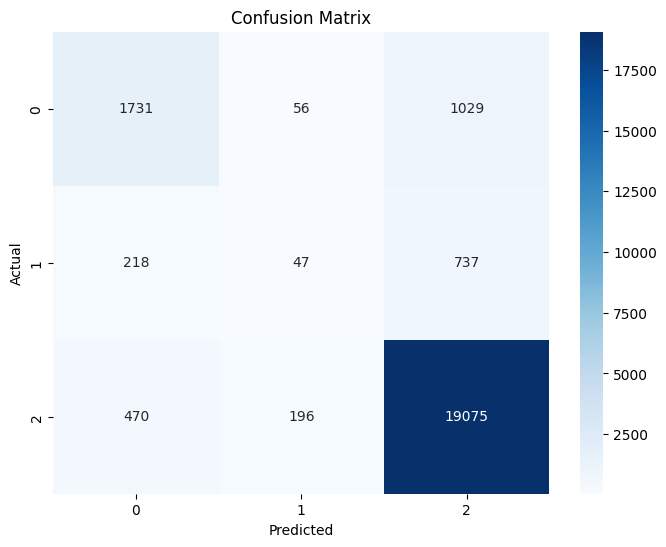

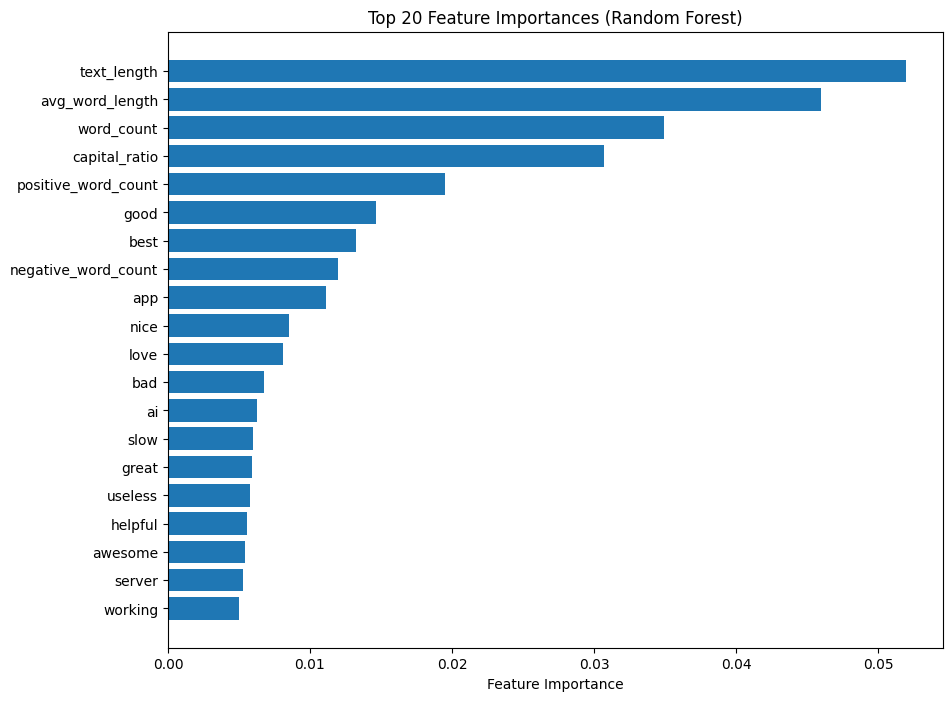

In [20]:
# Comprehensive evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

rf_model.fit(X_train, y_train)

# Feature importance analysis (for Random Forest)
feature_names = list(tfidf_vectorizer.get_feature_names_out()) + list(linguistic_features.columns)
top_features_idx = np.argsort(rf_model.feature_importances_)[::-1][:20]
top_features = [feature_names[i] for i in top_features_idx]
top_importances = rf_model.feature_importances_[top_features_idx]

plt.figure(figsize=(10, 8))
plt.barh(range(len(top_features)), top_importances)
plt.yticks(range(len(top_features)), top_features)
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances (Random Forest)')
plt.gca().invert_yaxis()
plt.show()

In [25]:
# Create reusable preprocessing and prediction functions
import joblib

class SentimentClassifierPipeline:
    def __init__(self):
        self.tfidf_vectorizer = None
        self.model = None
        self.label_encoder = None
        
    def preprocess_text(self, text):
        """Preprocess a single text sample"""
        # Clean text
        if not isinstance(text, str):
            return ''
        
        text = clean_text(text)
        
        # Tokenize, lemmatize, remove stopwords
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
        
        return ' '.join(tokens)
    
    def extract_linguistic_features(self, text):
        """Extract linguistic features from text"""
        features = []
        text = str(text)
        
        # Text statistics
        text_length = len(text)
        word_count = len(text.split())
        avg_word_length = text_length / (word_count + 1)
        features.extend([text_length, word_count, avg_word_length])
        
        # Punctuation density
        exclamation_count = text.count('!')
        question_count = text.count('?')
        punctuation_density = (exclamation_count + question_count) / (text_length + 1)
        features.extend([exclamation_count, question_count, punctuation_density])
        
        # Capitalization ratio
        capital_ratio = sum(1 for c in text if c.isupper()) / (len(text) + 1)
        features.append(capital_ratio)
        
        # Simplified sentiment lexicon scores
        positive_words = ['good', 'great', 'excellent', 'amazing', 'wonderful', 'fantastic']
        negative_words = ['bad', 'terrible', 'awful', 'horrible', 'worst', 'disappointing']
        
        processed_text = self.preprocess_text(text)
        positive_word_count = sum(1 for word in processed_text.split() if word in positive_words)
        negative_word_count = sum(1 for word in processed_text.split() if word in negative_words)
        features.extend([positive_word_count, negative_word_count])
        
        return np.array(features).reshape(1, -1)
    
    def fit(self, texts, labels):
        """Fit the pipeline"""
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        # Initialize and fit TF-IDF vectorizer
        self.tfidf_vectorizer = TfidfVectorizer(
            max_features=10000,
            ngram_range=(1, 3),
            min_df=2,
            max_df=0.95,
            stop_words='english'
        )
        tfidf_features = self.tfidf_vectorizer.fit_transform(processed_texts)
        
        # Extract linguistic features
        linguistic_features_list = [self.extract_linguistic_features(text) for text in texts]
        linguistic_features = np.vstack(linguistic_features_list)
        
        # Combine features
        combined_features = hstack([tfidf_features, linguistic_features])
        
        # Encode labels
        self.label_encoder = LabelEncoder()
        encoded_labels = self.label_encoder.fit_transform(labels)
        
        # Train model
        self.model = LogisticRegression(random_state=42, max_iter=1000)
        self.model.fit(combined_features, encoded_labels)
        
        return self
    
    def predict(self, texts):
        """Predict sentiments for texts"""
        if self.model is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        # Extract TF-IDF features
        tfidf_features = self.tfidf_vectorizer.transform(processed_texts)
        
        # Extract linguistic features
        linguistic_features_list = [self.extract_linguistic_features(text) for text in texts]
        linguistic_features = np.vstack(linguistic_features_list)
        
        # Combine features
        combined_features = hstack([tfidf_features, linguistic_features])
        
        # Make predictions
        predictions = self.model.predict(combined_features)
        
        # Decode labels
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, texts):
        """Predict sentiment probabilities for texts"""
        if self.model is None:
            raise ValueError("Model not fitted yet. Call fit() first.")
        
        # Preprocess texts
        processed_texts = [self.preprocess_text(text) for text in texts]
        
        # Extract TF-IDF features
        tfidf_features = self.tfidf_vectorizer.transform(processed_texts)
        
        # Extract linguistic features
        linguistic_features_list = [self.extract_linguistic_features(text) for text in texts]
        linguistic_features = np.vstack(linguistic_features_list)
        
        # Combine features
        combined_features = hstack([tfidf_features, linguistic_features])
        
        # Make probability predictions
        return self.model.predict_proba(combined_features)
    
    def save_model(self, filepath):
        """Save the trained pipeline"""
        joblib.dump(self, filepath)
    
    @staticmethod
    def load_model(filepath):
        """Load a trained pipeline"""
        return joblib.load(filepath)

# Train the production pipeline
print("Training production pipeline...")
production_pipeline = SentimentClassifierPipeline()
production_pipeline.fit(train_df['Comment'], train_df['Sentiment'])

# Test the pipeline
test_texts = [
    "This LLM is absolutely fantastic! Great responses.",
    "Terrible performance, very disappointed with the results.",
    "It's okay, nothing special but does the job."
]

predictions = production_pipeline.predict(test_texts)
probabilities = production_pipeline.predict_proba(test_texts)

for text, pred, prob in zip(test_texts, predictions, probabilities):
    print(f"Text: {text}")
    print(f"Predicted Sentiment: {pred}")
    print(f"Probabilities: {prob}")
    print("-" * 50)

# Save the model
production_pipeline.save_model('sentiment_classifier_pipeline.pkl')
print("Model saved successfully!")

Training production pipeline...
Text: This LLM is absolutely fantastic! Great responses.
Predicted Sentiment: 2
Probabilities: [0.0021885 0.0112493 0.9865622]
--------------------------------------------------
Text: Terrible performance, very disappointed with the results.
Predicted Sentiment: 0
Probabilities: [0.93975605 0.00966586 0.05057809]
--------------------------------------------------
Text: It's okay, nothing special but does the job.
Predicted Sentiment: 2
Probabilities: [0.11915709 0.06717107 0.81367184]
--------------------------------------------------
Model saved successfully!


In [ ]:
# Load and process test data
def load_test_data(data_dir='data/Test'):
    """Load and combine all test CSV files from different LLMs"""
    all_data = []
    
    # List of LLM platforms
    llm_platforms = ['claude', 'deepseek', 'gemini', 'gpt', 'grok', 'perplexity']
    
    for platform in llm_platforms:
        file_path = os.path.join(data_dir, f'{platform}.csv')
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df['Platform'] = platform  # Add platform identifier
            all_data.append(df)
        else:
            print(f"Warning: File {file_path} not found")
    
    # Combine all dataframes
    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

# Load test data
test_df = load_test_data()
print("Test data shape:", test_df.shape)
print(test_df.head())

Test data shape: (45971, 5)
   CommentId                                            Comment  \
0          1  So this length limit issue has ruined Claude f...   
1          2                        Great Ai consultation tool.   
2          3  I am a pro user and I think there is a bug in ...   
3          4                                   I love Claude AI   
4          5  No access to live data without subscription (p...   

                    At   AppVersion Platform  
0  2025-06-22 22:55:09  1.250609.27   claude  
1  2024-09-14 06:07:28  1.240909.27   claude  
2  2024-11-19 13:15:37  1.241118.17   claude  
3  2024-12-06 19:03:26   1.241125.6   claude  
4  2025-03-05 20:06:49  1.250303.27   claude  


In [37]:
# Generate predictions for test data
print("Generating predictions for test data...")

# Use the production pipeline to make predictions
test_predictions = production_pipeline.predict(test_df['Comment'])

all_data = []
    
# List of LLM platforms
llm_platforms = ['claude', 'deepseek', 'gemini', 'gpt', 'grok', 'perplexity']

data_dir = 'data/Test'

for platform in llm_platforms:
    file_path = os.path.join(data_dir, f'{platform}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['Platform'] = platform  # Add platform identifier
        all_data.append(df)
    else:
        print(f"Warning: File {file_path} not found")

submission_data = []

for data in all_data:
    temp_pred = production_pipeline.predict(data['Comment'])
    # Create submission file
    data['submit_index'] = data['Platform'].astype(str) + "_" + data['CommentId'].astype(str)
    temp_submission_df = pd.DataFrame({
        'CommentId': data['submit_index'],
        'Sentiment': temp_pred
    })
    submission_data.append(temp_submission_df)


# # Create submission file
# submission_df = pd.DataFrame({
#     'CommentId': test_df['CommentId'],
#     'Sentiment': test_predictions
# })

# Save submission file
submission_df = pd.concat(submission_data, ignore_index=True)
submission_df.to_csv('submission.csv', index=False)
print("Submission file created successfully!")

# Display submission file info
print("\nSubmission file info:")
print(submission_df.head())
print("\nSentiment distribution in predictions:")
print(submission_df['Sentiment'].value_counts())

Generating predictions for test data...
Submission file created successfully!

Submission file info:
  CommentId  Sentiment
0  claude_1          0
1  claude_2          2
2  claude_3          0
3  claude_4          2
4  claude_5          2

Sentiment distribution in predictions:
Sentiment
2    42451
0     3496
1       24
Name: count, dtype: int64


Model Performance Comparison:
                 Model  Accuracy
0  Logistic Regression  0.700964
1        Random Forest  0.768411
2     Ensemble (LR+RF)  0.885139
3  Production Pipeline  0.885139


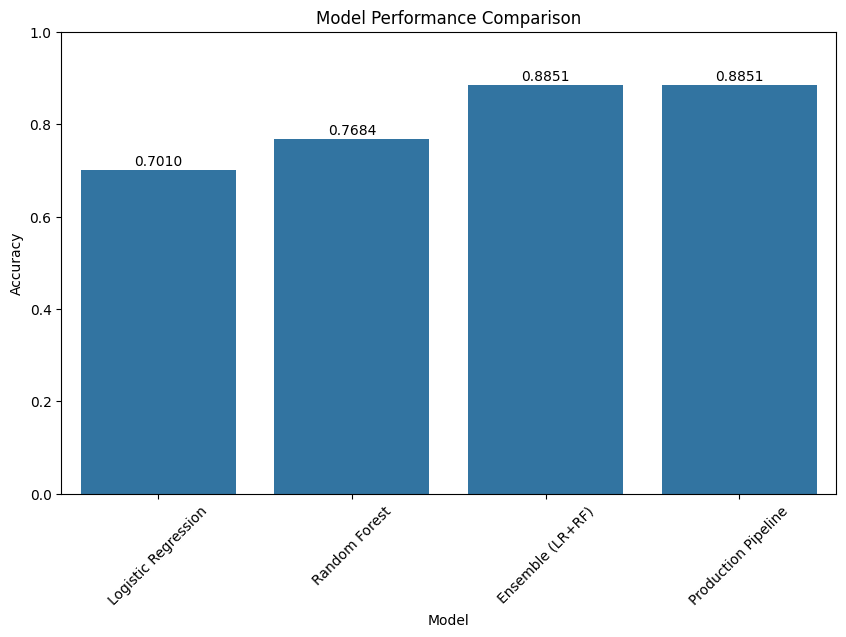

In [38]:
# Model performance comparison table
performance_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Ensemble (LR+RF)', 'Production Pipeline'],
    'Accuracy': [lr_accuracy, rf_accuracy, ensemble_accuracy, ensemble_accuracy]  # Using ensemble accuracy as proxy
})

print("Model Performance Comparison:")
print(performance_table)

# Visualization of model performance
plt.figure(figsize=(10, 6))
sns.barplot(data=performance_table, x='Model', y='Accuracy')
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.ylim(0, 1)
for i, v in enumerate(performance_table['Accuracy']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()